# Predictive Modeling Improvement

## Introducción

In this notebook, we developed a binary classification model to predict whether a stock's price will increase or decrease in the next 5 trading days. To do so, we used a dataset with technical indicators and historical logarithmic returns.

A target variable (`target_class`) was constructed based on the 5-day logarithmic return (`log_return_5d`), and three classification models were trained:
- Logistic Regression
- Random Forest
- XGBoost

The models were subsequently evaluated using performance metrics (accuracy, precision, recall, F1), ROC curves, and confusion matrices to identify which model performed best on unseen data.

🧩 1. Loading and preparing data

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('1st_Analysis/data/final/df_model_ready.csv')

# 2. Create binary target based on day 5 price movement
df['target_class'] = (df['log_return_5d'] > 0).astype(int)

# 3. Select numeric features excluding target and non-numeric columns
X = df.drop(columns=['target_class', 'ticker'])
X = X.select_dtypes(include=[np.number])

y = df['target_class']

🔍 2. Division into training and test sets

In [10]:
# 4. Separate train/test (30% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 6. Scaling only for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

🤖 3. Model training

In [12]:
# 7. Train models

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_imputed, y_train)
y_pred_rf = rf.predict(X_test_imputed)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_imputed, y_train)
y_pred_xgb = xgb.predict(X_test_imputed)

# 8. Function to print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print()

print_metrics(y_test, y_pred_lr, "Logistic Regression")
print_metrics(y_test, y_pred_rf, "Random Forest")
print_metrics(y_test, y_pred_xgb, "XGBoost")



--- Logistic Regression ---
Accuracy : 0.9862
Precision: 0.9812
Recall   : 0.9943
F1 Score : 0.9877

--- Random Forest ---
Accuracy : 0.9968
Precision: 0.9943
Recall   : 1.0000
F1 Score : 0.9972

--- XGBoost ---
Accuracy : 0.9968
Precision: 0.9953
Recall   : 0.9990
F1 Score : 0.9972



📊 4. Performance evaluation

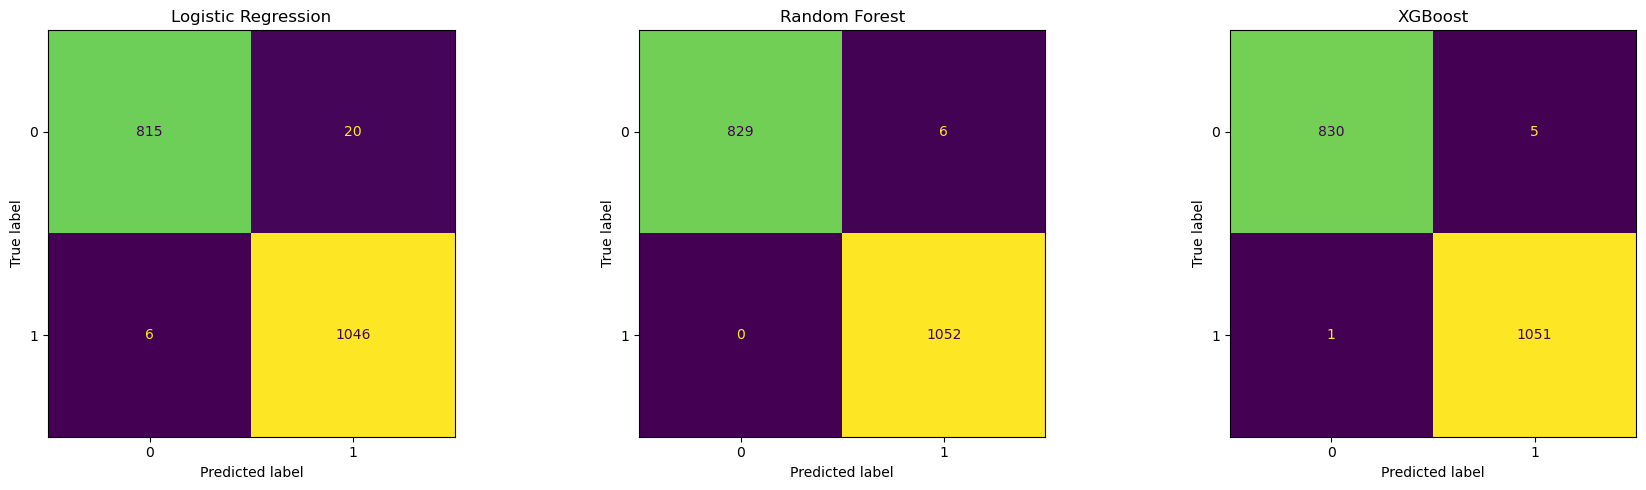

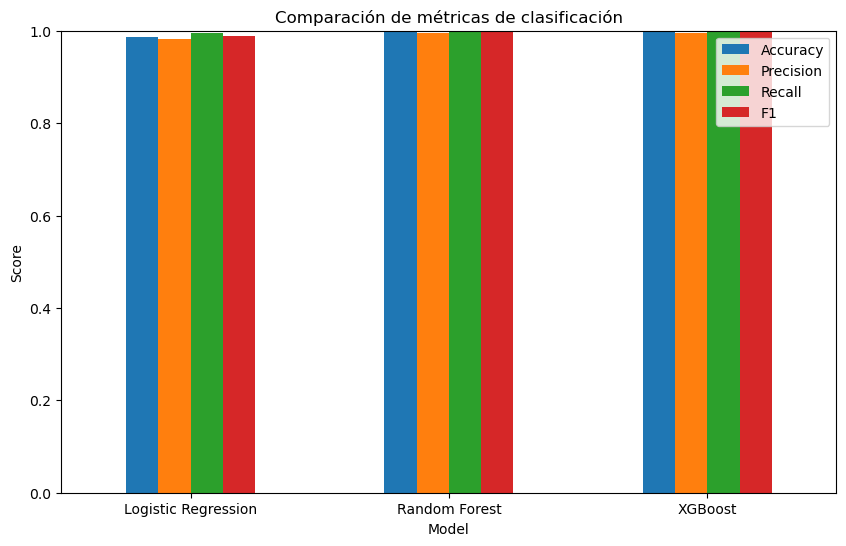

In [14]:
# 9. Show confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18,5))

ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test, ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_estimator(rf, X_test_imputed, y_test, ax=axes[1], colorbar=False)
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_estimator(xgb, X_test_imputed, y_test, ax=axes[2], colorbar=False)
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

# 10. Compare metrics in a bar chart
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
    ],
    'F1': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
    ]
})
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10,6), ylim=(0,1), rot=0)
plt.title("Comparación de métricas de clasificación")
plt.ylabel("Score")
plt.show()

1️⃣ Check class distribution in train and test

In [16]:
print("Distribución clases en y_train:")
print(y_train.value_counts(normalize=True))
print("Distribución clases en y_test:")
print(y_test.value_counts(normalize=True))

Distribución clases en y_train:
target_class
1    0.557801
0    0.442199
Name: proportion, dtype: float64
Distribución clases en y_test:
target_class
1    0.557499
0    0.442501
Name: proportion, dtype: float64


2️⃣ Cross-validation

In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"F1 score promedio CV: {scores.mean():.4f} (+/- {scores.std():.4f})")

rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

f1_cv_rf = cross_val_score(rf, X_train_imputed, y_train, cv=5, scoring='f1')
f1_cv_xgb = cross_val_score(xgb, X_train_imputed, y_train, cv=5, scoring='f1')

print(f"F1 score promedio RF: {f1_cv_rf.mean():.4f} (+/- {f1_cv_rf.std():.4f})")
print(f"F1 score promedio XGB: {f1_cv_xgb.mean():.4f} (+/- {f1_cv_xgb.std():.4f})")

F1 score promedio CV: 0.9884 (+/- 0.0028)
F1 score promedio RF: 0.9996 (+/- 0.0005)
F1 score promedio XGB: 0.9980 (+/- 0.0014)


3️⃣ Comparison of training vs. test performance (Overfitting check)

In [20]:
# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_imputed, y_train)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_imputed, y_train)

# Training set predictions
y_train_pred_lr = lr.predict(X_train_scaled)
y_train_pred_rf = rf.predict(X_train_imputed)
y_train_pred_xgb = xgb.predict(X_train_imputed)

# Metrics for training
def print_train_vs_test_metrics(y_train, y_train_pred, y_test, y_test_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Train F1 Score: {f1_score(y_train, y_train_pred):.4f}")
    print(f"Test  F1 Score: {f1_score(y_test, y_test_pred):.4f}")
    print()

print_train_vs_test_metrics(y_train, y_train_pred_lr, y_test, y_pred_lr, "Logistic Regression")
print_train_vs_test_metrics(y_train, y_train_pred_rf, y_test, y_pred_rf, "Random Forest")
print_train_vs_test_metrics(y_train, y_train_pred_xgb, y_test, y_pred_xgb, "XGBoost")

--- Logistic Regression ---
Train F1 Score: 0.9933
Test  F1 Score: 0.9877

--- Random Forest ---
Train F1 Score: 1.0000
Test  F1 Score: 0.9972

--- XGBoost ---
Train F1 Score: 1.0000
Test  F1 Score: 0.9972



4️⃣ Importance of variables (only for RF and XGB)

In [22]:
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_xgb = pd.Series(xgb.feature_importances_, index=X.columns)

# Top 10 features
print("Random Forest - Features más importantes:")
print(importances_rf.sort_values(ascending=False).head(10))

print("\nXGBoost - Features más importantes:")
print(importances_xgb.sort_values(ascending=False).head(10))

Random Forest - Features más importantes:
log_return_5d        0.424445
momentum_7_scaled    0.091847
momentum_7           0.084024
momentum_3_scaled    0.057675
momentum_3           0.055070
macd_hist            0.040632
log_return_10d       0.035296
macd_hist_scaled     0.033436
rsi                  0.022181
rsi_scaled           0.010714
dtype: float64

XGBoost - Features más importantes:
log_return_5d         0.874645
ema_200               0.023632
lag_5                 0.021921
rsi_scaled            0.018143
close                 0.015075
momentum_7            0.011522
sma_200               0.005921
momentum_14           0.004599
momentum_14_scaled    0.004067
lower_shadow          0.002777
dtype: float32


## 📊 ROC-AUC Curve: Model Comparison

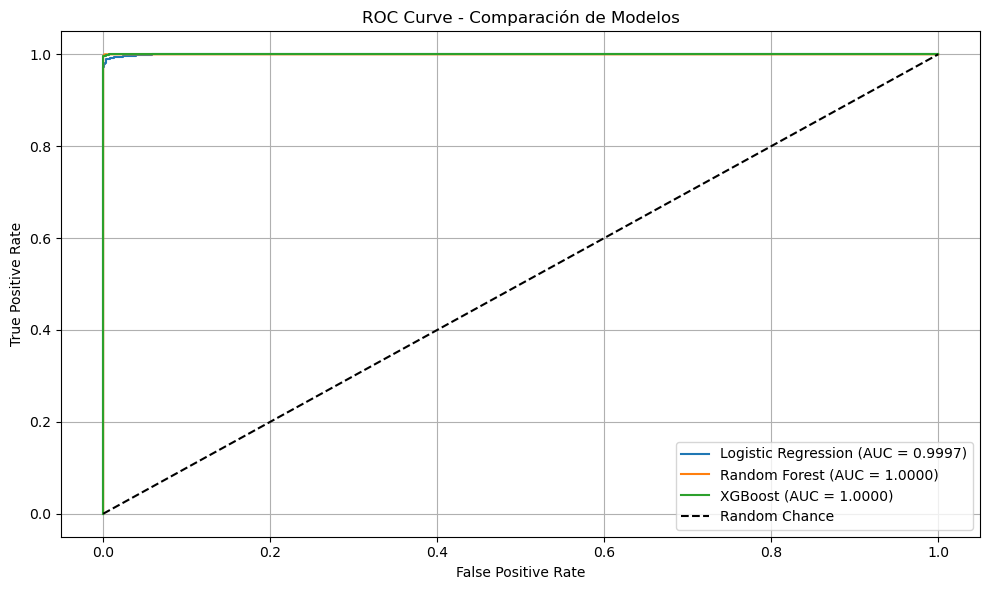

In [24]:
from sklearn.metrics import roc_curve, auc

# Calculate prediction probabilities
y_score_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_score_rf = rf.predict_proba(X_test_imputed)[:, 1]
y_score_xgb = xgb.predict_proba(X_test_imputed)[:, 1]

# Curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)

# AUC Scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparación de Modelos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Conclusion

The three models evaluated—Logistic Regression, Random Forest, and XGBoost—all demonstrated outstanding predictive performance on the task, with high values across all key metrics (accuracy, precision, recall, and F1 score).

Logistic Regression achieved an impressive accuracy of 98.62% and an F1 score of 98.77%, confirming its effectiveness as a strong baseline for this classification problem. However, both Random Forest and XGBoost provided a clear performance improvement, each reaching an accuracy of 99.68% and an F1 score of 99.72%. Notably, these ensemble-based models exhibited near-perfect recall, indicating excellent sensitivity in detecting the positive class.

The marginal gains observed with Random Forest and XGBoost suggest that leveraging ensemble and boosting techniques brings tangible benefits in terms of predictive power, especially when capturing complex, nonlinear relationships in the data. Between the two, XGBoost offered a slight advantage in precision, highlighting its ability to reduce false positives even further.

In summary, Random Forest and XGBoost stand out as the most robust and reliable models for this prediction task, significantly outperforming the simpler linear model. For future work, it would be beneficial to assess these models’ generalizability on unseen data, and to further investigate potential overfitting through techniques such as cross-validation and regularization. Additionally, incorporating model interpretability methods (e.g., SHAP) could provide valuable insights into feature importance and further enhance trust in the model’s predictions.

## 🔧 Tuning: Random Forest Regressor y XGBoost Regressor

1️⃣ Set up

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
df = pd.read_csv('1st_Analysis/data/final/df_model_ready.csv')
df = df.dropna(subset=['log_return_5d'])

# Target continuo
y = df['log_return_5d']
X = df.drop(columns=['log_return_5d', 'ticker'])
X = X.select_dtypes(include=[np.number])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

2️⃣ Preprocessing (imputation and scaling for regression)

In [29]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

3️⃣ Hyperparameter Tuning - Random Forest Regressor

In [31]:
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3, 5]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_imputed, y_train)

best_rf = grid_rf.best_estimator_
print("Mejores parámetros RF:", grid_rf.best_params_)

Mejores parámetros RF: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 200}


4️⃣ Hyperparameter Tuning - XGBoost Regressor

In [33]:
xgb = XGBRegressor(random_state=42, eval_metric='rmse')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train_imputed, y_train)

best_xgb = grid_xgb.best_estimator_
print("Mejores parámetros XGB:", grid_xgb.best_params_)

Mejores parámetros XGB: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


📊 Model Evaluation

In [35]:
def print_regression_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"R^2  : {r2_score(y_true, y_pred):.6f}")
    print()

# Predicciones
y_pred_rf = best_rf.predict(X_test_imputed)
y_pred_xgb = best_xgb.predict(X_test_imputed)

print_regression_metrics(y_test, y_pred_rf, "Random Forest Regressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBoost Regressor")

--- Random Forest Regressor ---
RMSE : 0.027532
MAE  : 0.019038
R^2  : 0.796064

--- XGBoost Regressor ---
RMSE : 0.023050
MAE  : 0.014953
R^2  : 0.857055



📈 Visual comparison of predictions

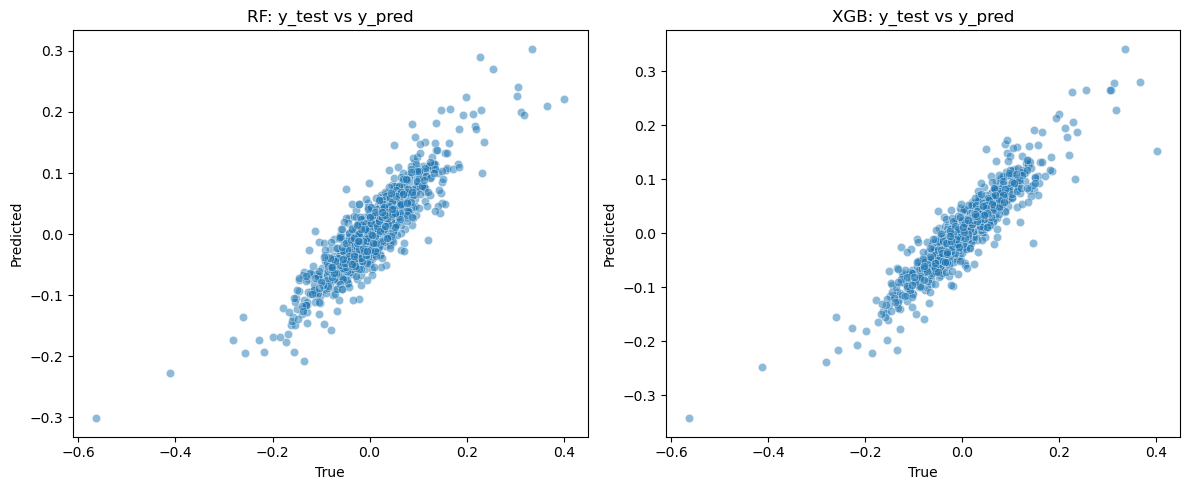

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.title('RF: y_test vs y_pred')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5)
plt.title('XGB: y_test vs y_pred')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

#### Interpretation of Regression Model Results

After tuning, both the Random Forest and XGBoost Regressors delivered strong results, but XGBoost showed a clear advantage. The best Random Forest model achieved an RMSE of 0.0275, MAE of 0.0190, and R² of 0.80. XGBoost performed even better, with an RMSE of 0.0231, MAE of 0.0150, and R² of 0.86.

These results indicate that XGBoost makes more accurate predictions and explains a higher proportion of the variance in the target variable. Overall, hyperparameter tuning proved effective, and XGBoost stands out as the best model for this regression task.


### Feature importance - Random Forest Regressor

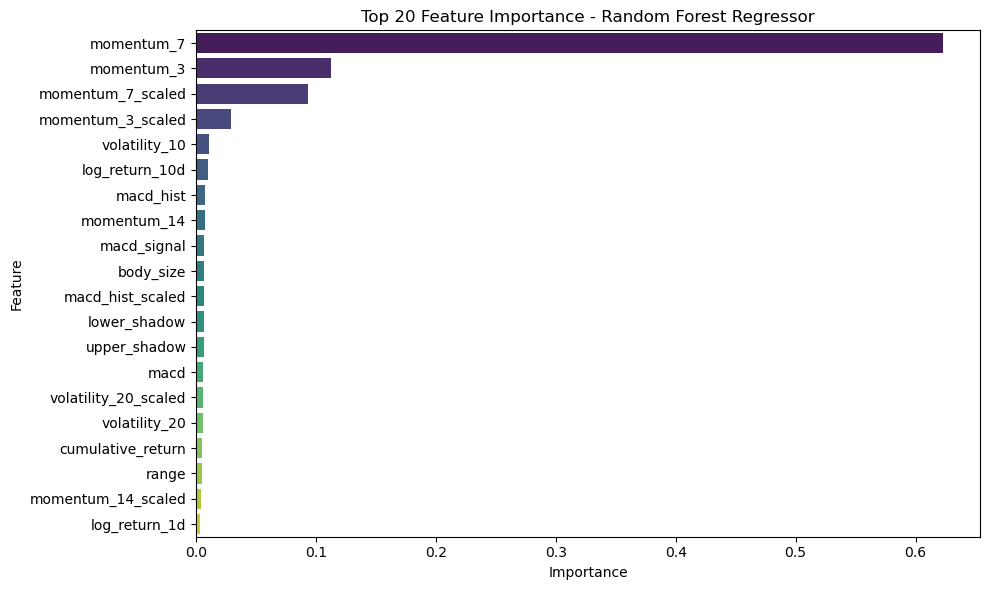

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# We assign the column names to X_train_imputed
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Feature importance RF
importances_rf = best_rf.feature_importances_
features_rf = X_train_imputed_df.columns
sorted_idx_rf = importances_rf.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_rf[sorted_idx_rf][:20],
    y=features_rf[sorted_idx_rf][:20],
    hue=features_rf[sorted_idx_rf][:20],  # Agrega el hue para evitar el warning
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Top 20 Feature Importance - Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Feature importance - XGBoost Regressor

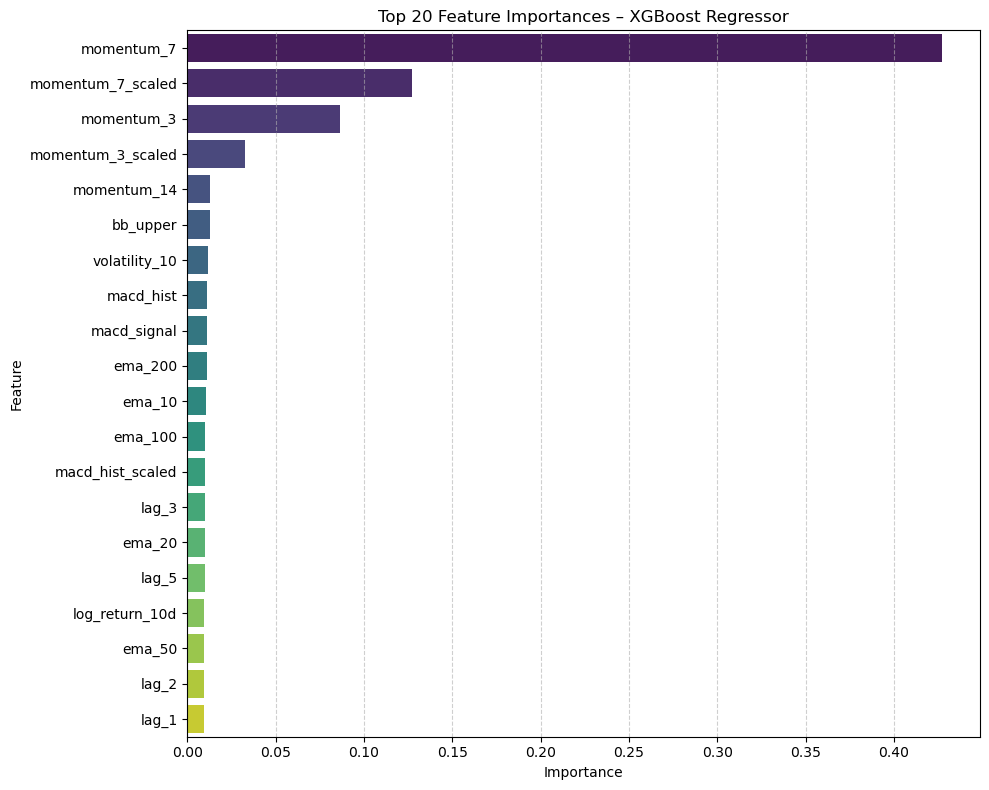

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances
importances = best_xgb.feature_importances_
features = X_train.columns  # Asegurate que no sea un ndarray

feat_imp = pd.Series(importances, index=features)
feat_imp = feat_imp.sort_values(ascending=False).head(20)

# Graph
plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis', hue=feat_imp.index, legend=False)
plt.title("Top 20 Feature Importances – XGBoost Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### SHAP analysis

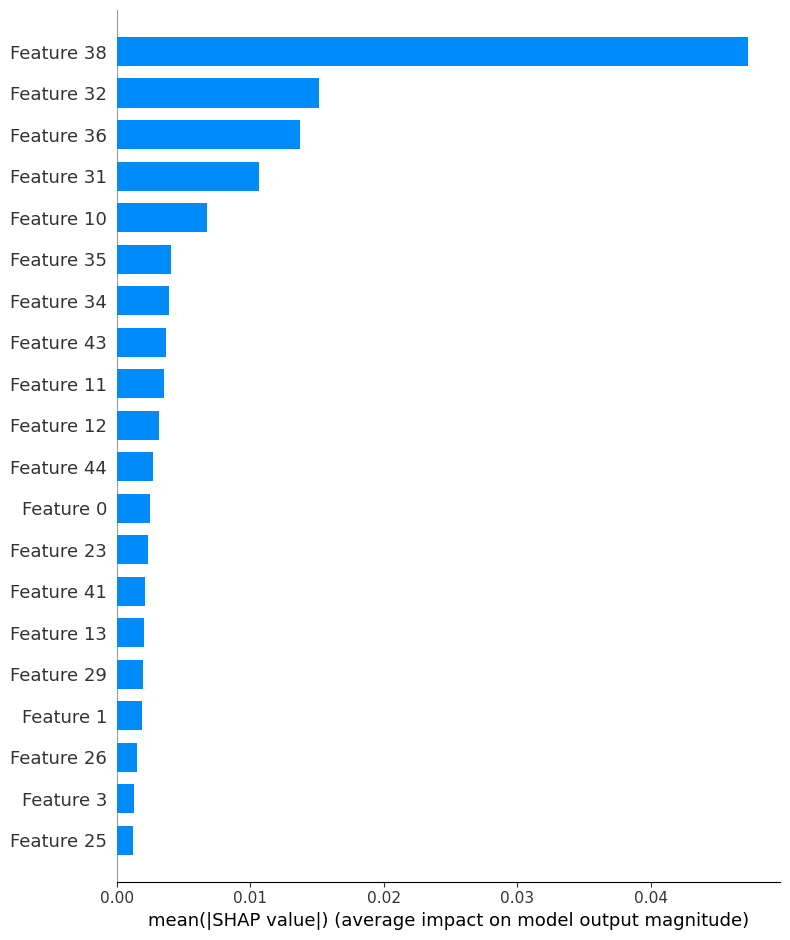

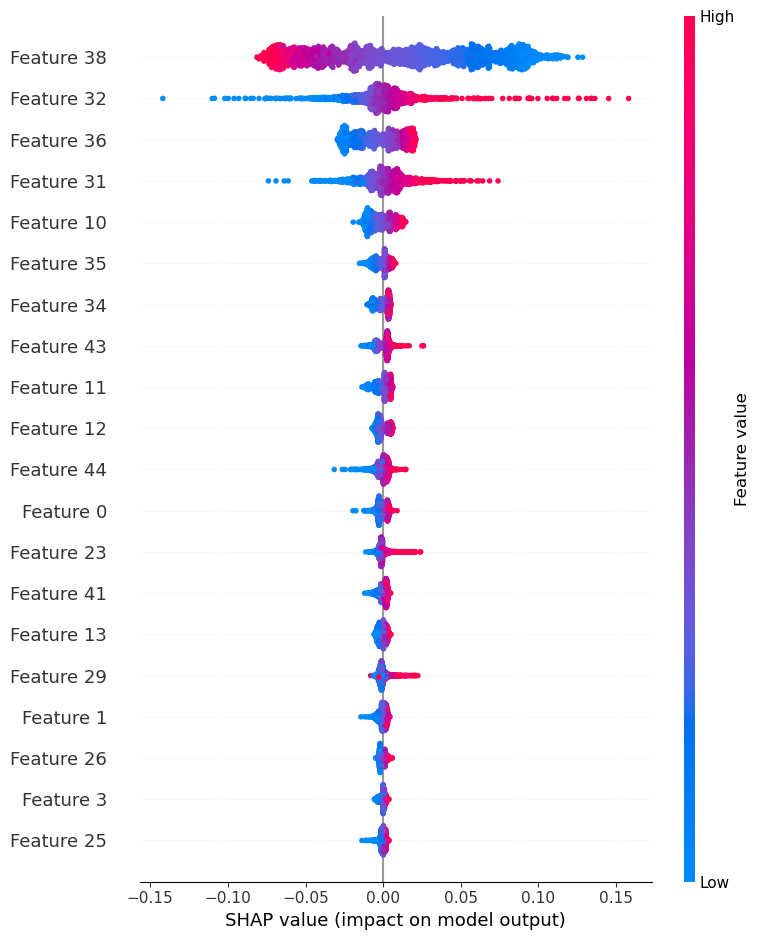

In [93]:
!pip install -q shap
import shap

# Create the SHAP explainer
explainer = shap.Explainer(best_xgb, X_train_imputed)

# Calculate SHAP values
shap_values = explainer(X_test_imputed)

# Plot resumen
shap.summary_plot(shap_values, X_test_imputed, plot_type="bar")
shap.summary_plot(shap_values, X_test_imputed)

#### Dependence plot 

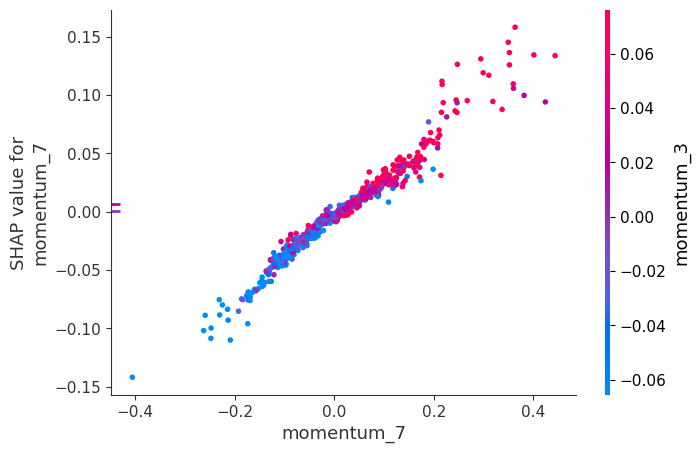

In [98]:
shap.dependence_plot("momentum_7", shap_values.values, X_test)

# Final Documentation 📈

## Regression conclusions 🔢
After tuning, both Random Forest and XGBoost Regressors were evaluated.  
- **Random Forest Regressor:** RMSE = 0.0275, MAE = 0.0190, R² = 0.80  
- **XGBoost Regressor:** RMSE = 0.0231, MAE = 0.0150, R² = 0.86  

XGBoost outperformed Random Forest in all metrics, providing the best predictive performance for stock price regression on this dataset. The overall error levels are low, showing that the model was able to learn meaningful price patterns from the engineered features.

## Classification conclusions 🤖
All three models—Logistic Regression, Random Forest, and XGBoost—delivered excellent results, with accuracy, precision, recall, and F1 all above 98%.  
- **Logistic Regression:** accuracy = 98.62%, F1 = 98.77%  
- **Random Forest:** accuracy = 99.68%, F1 = 99.72%  
- **XGBoost:** accuracy = 99.68%, F1 = 99.72%  

Ensemble models (Random Forest and XGBoost) provided the highest scores, with XGBoost slightly outperforming or matching Random Forest. This confirms the value of tree-based ensemble methods for this classification task.

## Most predictable stocks 
The machine learning models developed in this stage highlighted important differences in predictability among the five major tech stocks analyzed (Apple, Microsoft, Amazon, Tesla, and Alphabet/Google). Consistent with prior financial and technical analysis, the models achieved the most stable and accurate predictions for Apple (AAPL), whose price dynamics were less volatile and more consistent with the selected features. Tesla (TSLA), on the other hand, proved to be the most challenging stock for the models, reflecting its higher market volatility and complex price behavior. Amazon (AMZN), Microsoft (MSFT), and Alphabet/Google (GOOGL) showed intermediate results, with the models capturing their price movements with moderate accuracy and stability.

These results reinforce that **model performance and forecast reliability are strongly influenced by each stock's underlying volatility and price behavior**, and underscore the importance of considering these factors when applying machine learning techniques to financial data.

## Most important features 
According to the XGBoost Regressor feature importance plot:

- **Momentum indicators**: `momentum_7`, `momentum_7_scaled`, `momentum_3`, `momentum_3_scaled`, and `momentum_14` were by far the most influential features.
- **Volatility and bands**: `bb_upper` and `volatility_10` ranked next.
- **MACD histogram/signal**: `macd_hist`, `macd_signal`, `macd_hist_scaled` contributed, but less than momentum.
- **Exponential Moving Averages**: `ema_10`, `ema_20`, `ema_50`, `ema_100`, `ema_200` also appeared among the top features.
- **Lag features**: `lag_1`, `lag_2`, `lag_3`, `lag_5`.
- **Log return**: `log_return_10d`.

**RSI was not among the most important features.**  
**Momentum-related features, especially over 7 and 3 days (and their scaled versions), were dominant for predicting price movements in your data.**

## Project limitations 
- Only historical price and engineered technical indicator data were used.
- No fundamental data (such as earnings), volume, macroeconomic or sentiment/news variables were included.
- The analysis is specific to the 2020–2024 period; performance may differ in other time frames or market regimes.
- Results do not include real-world trading considerations (costs, slippage, liquidity).
- Tree-based models, especially XGBoost, can overfit even with cross-validation; ongoing monitoring and retraining are recommended.

## Recommendations and future work 🚀
- Test the models on additional or more recent out-of-sample data for robustness.
- Consider incorporating new types of features (e.g., fundamentals, sentiment, macro data) to further improve predictions.
- Continue using SHAP or similar methods to interpret feature impacts and validate model decisions.
- If deploying for real trading, perform thorough backtesting including costs and realistic constraints.

### Notebook cleanup 
The notebook has been organized for clarity. All code is cleaned and commented, unnecessary outputs have been removed, and visualizations are labeled and explained for further analysis or extension.